In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(0)

In [2]:
num_of_barriers = 25
num_of_trails = 100000 
dividinds_rate = 0
risk_free_rate = 0.03
strike_price = 105
initial_stock_price = 99
expiration_time = 25.0/252.0
volatility = 0.6
barrier_price = 90
    
delta_T = expiration_time/(num_of_barriers)
delta_R = (risk_free_rate-dividinds_rate-0.5*volatility*volatility)*delta_T
delta_SD = volatility*math.sqrt(delta_T)

# (a) Price a discrete down-and-out call option using plain vanilla Monte Carlo simulations.

In [14]:
def plain_MC():
    call_option_price = []
    
    for i in range(num_of_trails):
        current_stock_price = initial_stock_price
        for j in range(num_of_barriers):
            fi = np.random.normal(0.0, 1.0)
            if current_stock_price*math.exp(delta_R+delta_SD*fi) > barrier_price:
                current_stock_price = current_stock_price*math.exp(delta_R+delta_SD*fi)
            else: 
                current_stock_price = 0 
        
        call_price = max(0.0, current_stock_price-strike_price)
        call_option_price.append(call_price * math.exp(-risk_free_rate*expiration_time))
    
    V_call = np.mean(call_option_price)
    
    std = np.std(call_option_price)/math.sqrt(num_of_trails)
    
    act_sum = 0
    for i in range(num_of_trails):
        act_sum += (call_option_price[i]-4.647650)*(call_option_price[i]-4.647650)
    actual_error = math.sqrt(act_sum/(num_of_trails-1))
    actual_error /= math.sqrt(num_of_trails)
    
    return V_call, std, actual_error

In [15]:
V_call, std, actual_error = plain_MC()
print("Plain vanilla Monte Carlo Simulations")
print("option price estimate: ",V_call)
print("standard error:        ",std)
print("actual error:          ",actual_error)

Plain vanilla Monte Carlo Simulations
option price estimate:  4.63741653367863
standard error:         0.03228316428400126
actual error:           0.03228334192070403


# (b) Repeat part (a) using the plain vanilla European call option as a control variate.

In [16]:
Y = []
X = []
EX = initial_stock_price * math.exp(risk_free_rate*expiration_time)
control_variate = [] 

for i in range(num_of_trails):
    current_stock_price = initial_stock_price
    S_T = initial_stock_price
    for j in range(num_of_barriers):
        fi = np.random.normal(0.0, 1.0)
        S_T = S_T * math.exp(delta_R+delta_SD*fi)
        if current_stock_price*math.exp(delta_R+delta_SD*fi) > barrier_price:
            current_stock_price = current_stock_price*math.exp(delta_R+delta_SD*fi)
        else: 
            current_stock_price = 0 
            
    X.append(S_T)
    control_variate.append(S_T - EX)        
    call_price = max(0.0, current_stock_price-strike_price)
    Y.append(call_price)


In [17]:
X = sm.add_constant(X) 
model = sm.OLS(Y, X).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                 1.661e+05
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:24:08   Log-Likelihood:            -3.2601e+05
No. Observations:              100000   AIC:                         6.520e+05
Df Residuals:                   99998   BIC:                         6.520e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.8542      0.106   -356.132      0.0

In [18]:
R_2 = model.rsquared
b_star = model.params[1]

print("R_2 = ", R_2)
print("b* = ", b_star) 

R_2 =  0.6241743314366484
b* =  0.42813405861834836


In [19]:
def variance_reduction_MC():
    Y_b = []
    EX = initial_stock_price * math.exp(risk_free_rate*expiration_time)
    for i in range(num_of_trails):
        current_stock_price = initial_stock_price
        S_T = initial_stock_price
        for j in range(num_of_barriers):
            fi = np.random.normal(0.0, 1.0)
            S_T = S_T * math.exp(delta_R+delta_SD*fi)
            if current_stock_price*math.exp(delta_R+delta_SD*fi) > barrier_price:
                current_stock_price = current_stock_price*math.exp(delta_R+delta_SD*fi)
            else: 
                current_stock_price = 0 
                   
        call_price = max(0.0, current_stock_price-strike_price) * math.exp(-risk_free_rate*expiration_time)
        Y_b.append(call_price - b_star *(S_T - EX))
    
    V_call = np.mean(Y_b)
    
    std = np.std(Y_b)/math.sqrt(num_of_trails)
    
    act_sum = 0
    for i in range(num_of_trails):
        act_sum += (Y_b[i]-4.647650)*(Y_b[i]-4.647650)
    actual_error = math.sqrt(act_sum/(num_of_trails-1))
    actual_error /= math.sqrt(num_of_trails)
    
    return V_call, std, actual_error

In [20]:
V, s, a = variance_reduction_MC()
print("Variance Reduction Monte Carlo Simulations")
print("(using the plain vanilla European call option as a control variate)")
print("option price estimate: ",V)
print("standard error:        ",s)
print("actual error:          ",a)

Variance Reduction Monte Carlo Simulations
(using the plain vanilla European call option as a control variate)
option price estimate:  4.642358370295313
standard error:         0.01978073658815902
actual error:           0.019780842570550662


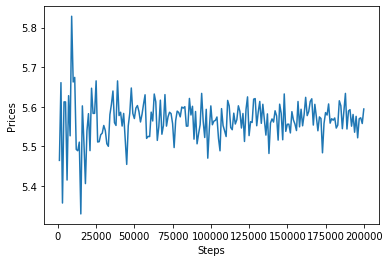

In [7]:
#This is for question 5(a) 
conv = pd.read_csv("convergence.csv")
plt.plot(conv['steps'], conv['price'])
plt.xlabel('Steps')
plt.ylabel('Prices')
plt.show()